In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import requests as rq

from scipy import integrate
from scipy import optimize

### Define SEIR

In [24]:
def diff_eqns(y, t, beta, sigma, gamma, N):
    St, Et, It, Rt = y
    dSdt = -beta * St * It / N
    dEdt = beta * St * It / N - sigma * Et
    dIdt = sigma * Et - gamma * It
    dRdt = gamma * It
    return ([dSdt, dEdt, dIdt, dRdt])

def seir_model(t, beta, sigma, gamma, E0, N):
    S0 = N - E0
    I0 = R0 = 0
    out = integrate.odeint(diff_eqns, (S0, E0, I0, R0), t, args=(beta, sigma, gamma, N))
    return out.T # S, E, I, R

### Sample SEIR plot

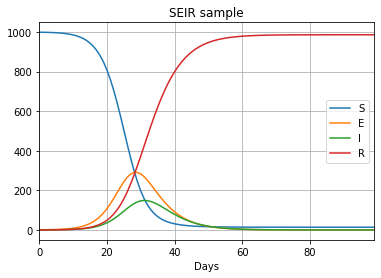

In [25]:
N = 1000
days = np.arange(100)
beta = 1.5
sigma = 1 / 5.2 # 5.2 days incubation, i.e. from exposed to infectious
gamma = 1 / 2.9 # 2.9 days from infectious to removal
S, E, I, R = seir_model(days, beta, sigma, gamma, 1, N)

df = pd.DataFrame({
    "Days": days,
    "S": S,
    "E": E,
    "I": I,
    "R": R
})

df.plot(
    x='Days',
    y=['S', 'E', 'I', 'R'],
    grid=True,
    title="SEIR sample"
)

### Fit Italy's data

In [8]:
it_df = pd.read_csv("csv/italy.csv", parse_dates=['date'])
it_df.sample()

,date,deceased,recovered,confirmed,active
83,2020-05-14,31368,115288.0,223096,76440


Params: [0.82670598]


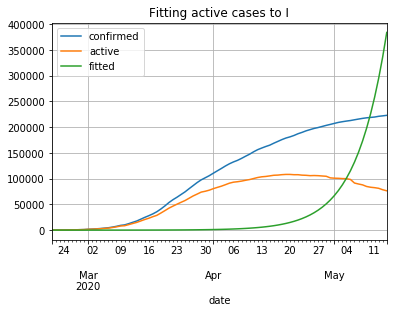

In [26]:
def seir_model_italy_i(t, beta):
    sigma = 1 / 5.2
    gamma = 1 / 2.9
    E0 = 19
    N = 60461826
    return seir_model(t, beta, sigma, gamma, E0, N)[2]

params, covar = optimize.curve_fit(seir_model_italy_i, it_df.index, it_df.confirmed)
it_df['fitted'] = seir_model_italy_i(it_df.index, *params)

print("Params:", params)
ax = it_df.plot(
    x='date',
    y=['confirmed', 'active', 'fitted'],
    grid=True,
    title="Fitting active cases to I"
)